In [11]:
import pandas as pd
import numpy as np
from scipy import stats
from handytool.scipy.stats import compare_pos_neg_groups
import matplotlib.pyplot as plt
from adjustText import adjust_text
plt.rcParams['font.family'] = 'Arial'

In [12]:
file_paths = {
    'PD': 'features_郊游风景图_v7.csv',
    'SN': 'features_三毛流浪记_v7.csv',
    'SR': 'features_牛郎织女_v7.csv'
}

data = {}
dict_discrim_feats = {}
results = {}
for task_type, file_path in file_paths.items():
    data[task_type] = pd.read_csv(file_path) # 读取 CSV 文件
    data[task_type] = data[task_type].drop(columns=['date_subject']) # 删除 'date_subject' 列
    data[task_type].loc[data[task_type]['label'] != 'CN', 'label'] = 'CI' # 将 'label' 列中除了 'CN' 之外的所有值替换为 'CI'
    results[task_type] = compare_pos_neg_groups(data[task_type], lab_column='label', pos_label='CI', neg_label='CN')
    print(results[task_type].head())

    
    #output_file = f'D:/Desktop/{task_type}-descriptive_results.xlsx' # 输出结果到 Excel 文件
    #results.to_excel(output_file, index=False)
    # 打印保存信息
    #print(f"Results for {task_type} have been saved to {output_file}")
    
    # 确保 u_p_value 和 auc 都为数值类型
    results[task_type]['u_p_value'] = pd.to_numeric(results[task_type]['u_p_value'], errors='coerce')
    results[task_type]['auc'] = pd.to_numeric(results[task_type]['auc'], errors='coerce')
    # 筛选出 u_p_value 小于 0.05 的行
    filtered_results = results[task_type][results[task_type]['u_p_value'] < 0.05]    
    #filtered_results = results[results['u_p_value'].astype(float) < 0.05]
    # 提取需要的列：feature、u_p_value 和 auc
    df_discrim_feats = filtered_results[['feature', 'u_p_value', 'auc']]
    print(f'Discriminative features in {task_type}:')
    print(df_discrim_feats)
    # 将结果保存到字典，以任务类型为键
    dict_discrim_feats[task_type] = df_discrim_feats
    
    

# 遍历字典并保存每个任务类型的结果到 CSV 文件
# for task_type, df in dict_discrim_feats.items():
#     output_file = f'D:/Desktop/{task_type}-filtered_results.csv'
#     df.to_csv(output_file, index=False)
#     print(f"Filtered results for {task_type} have been saved to {output_file}")

  feature pos_mean neg_mean pos_std neg_std pos_median neg_median  \
0     S/W     0.07     0.06    0.02    0.04       0.07       0.05   
1     C/W     0.20     0.20    0.03    0.03       0.20       0.20   
2     T/W     0.09     0.08    0.02    0.02       0.09       0.09   
3    UW/W     0.48     0.51    0.12    0.11       0.45       0.51   
4    RP/W     0.22     0.25    0.09    0.10       0.21       0.24   

  pos_25_percentile neg_25_percentile pos_75_percentile  ... t_stat t_p_value  \
0              0.05              0.03              0.09  ...   1.39      .172   
1              0.18              0.18              0.22  ...   0.15      .883   
2              0.07              0.07              0.10  ...   0.79      .433   
3              0.40              0.43              0.55  ...  -1.00      .324   
4              0.17              0.19              0.27  ...  -1.19      .239   

   u_stat u_p_value   auc safe_auc pos_shapiro_p pos_normality neg_shapiro_p  \
0  397.00      .05

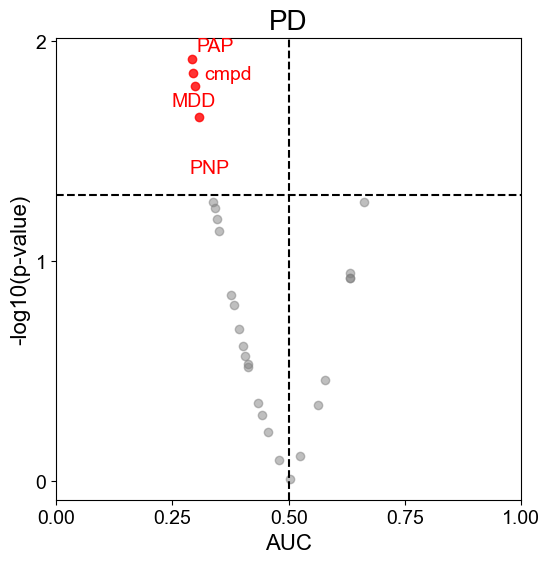

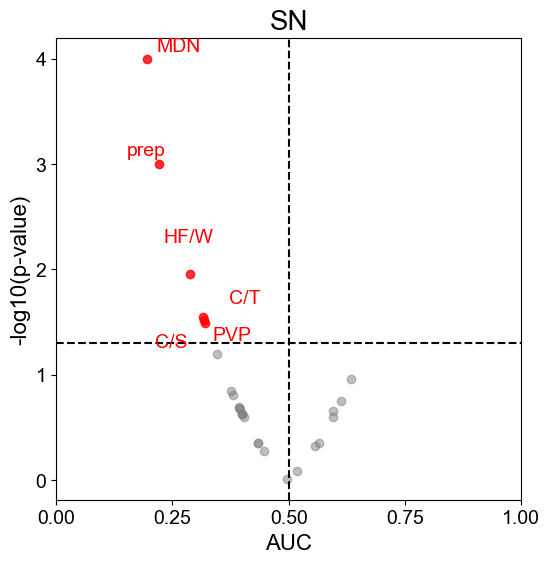

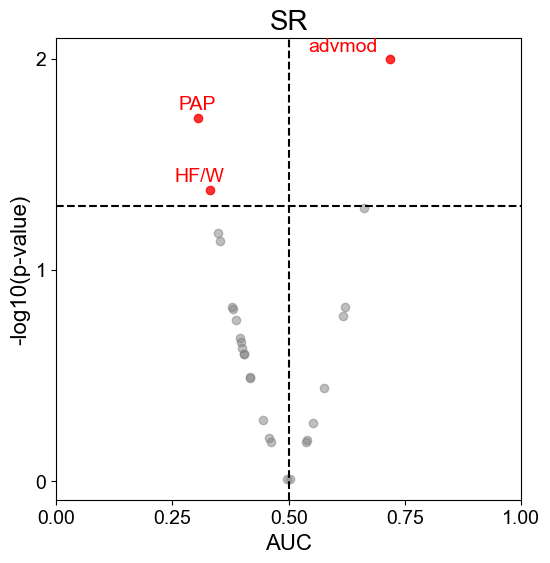

In [13]:
# 创建火山图
def plot_volcano(dict_results, task_type, dict_discrim_feats):
        #设一个临时变量
    results = dict_results[task_type]
    # 防止 p 值为 0 导致 -log10(0) 出现 inf
    results['u_p_value'] = results['u_p_value'].replace(0, 1e-4)

    # 计算 -log10(p-value) 作为 y 轴
    results['-log10(p-value)'] = -np.log10(results['u_p_value'])
    # 提取重要特征
    discrim_feats = dict_discrim_feats[task_type]
    
    # 画图
    plt.figure(figsize=(6, 6))
    
    # 绘制非重要特征（灰色）
    non_important = results[~results['feature'].isin(discrim_feats['feature'])]
    plt.scatter(non_important['auc'], non_important['-log10(p-value)'], color='gray', alpha=0.5, label='Non-discriminative features')
    
    # 绘制重要特征（深红色）
    important = results[results['feature'].isin(discrim_feats['feature'])]
    plt.scatter(important['auc'], important['-log10(p-value)'], color='red', alpha=0.8, label='Discriminative features')
    
    # 为重要特征添加名称标签
    texts = []
    for _, row in important.iterrows():
        #plt.text(row['auc'], row['-log10(p-value)'], row['feature'], fontsize=12, color='red', ha='right')
        texts.append(plt.text(row['auc'], row['-log10(p-value)'], row['feature'], fontsize=14, color='red', ha='right'))
    
     # 自动调整标签位置以避免重叠，并增加偏移量
    adjust_text(texts, 
                force_text=1.0,      # 控制标签之间的排斥力
                force_points=1.0,    # 控制标签和数据点之间的排斥力
                expand=(3, 1.5)
                #expand_text=(3, 3),  # 增加标签之间的间距
                #expand_points=(5, 3)    # 增加标签与数据点之间的距离
                #arrowprops=dict(arrowstyle='-', color='red', lw=1.0)  # 使用箭头表示标签归属
               )
    
    # 设置图例和轴标签
    plt.axhline(y=-np.log10(0.05), color='black', linestyle='--')  # y轴基线
    plt.axvline(x=0.5, color='black', linestyle='--')  # x轴基线
    plt.xlim(0, 1)
    #plt.ylim(0, 8)
    plt.xticks(np.arange(0, 1.1, 0.25), fontsize=14)
    max_value = results['-log10(p-value)'].max()
    plt.yticks(np.arange(0, np.ceil(max_value) + 1, 1), fontsize=14)
    plt.xlabel('AUC', fontsize=16)
    plt.ylabel('-log10(p-value)', fontsize=16)
    plt.title(task_type, fontsize=20)
    #plt.legend()
    plt.grid(False)
    #plt.savefig(f'volcano-{task_type}.svg', format='svg')
    # 显示图形
    plt.show()
    

# 假设 task_type 是 'SR'，并且你已经有 dict_discrim_feats 数据
plot_volcano(results, 'PD', dict_discrim_feats)
plot_volcano(results, 'SN', dict_discrim_feats)
plot_volcano(results, 'SR', dict_discrim_feats)

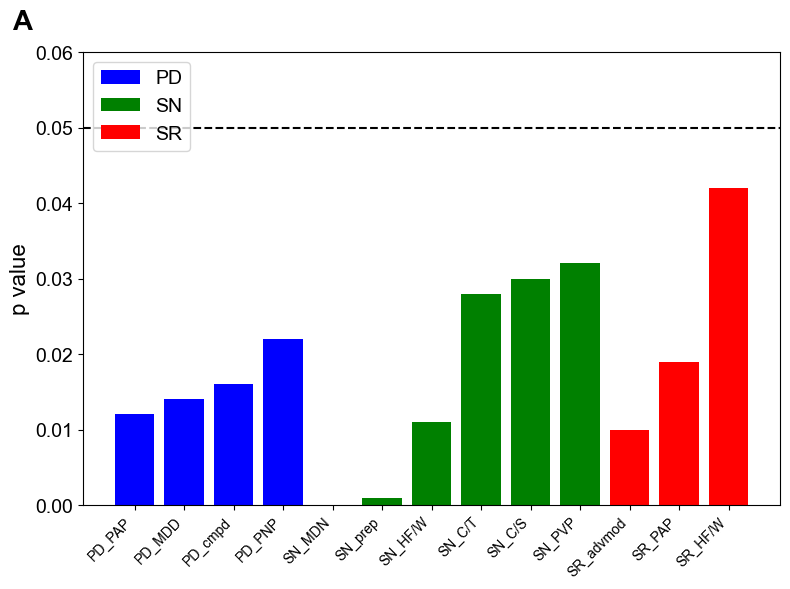

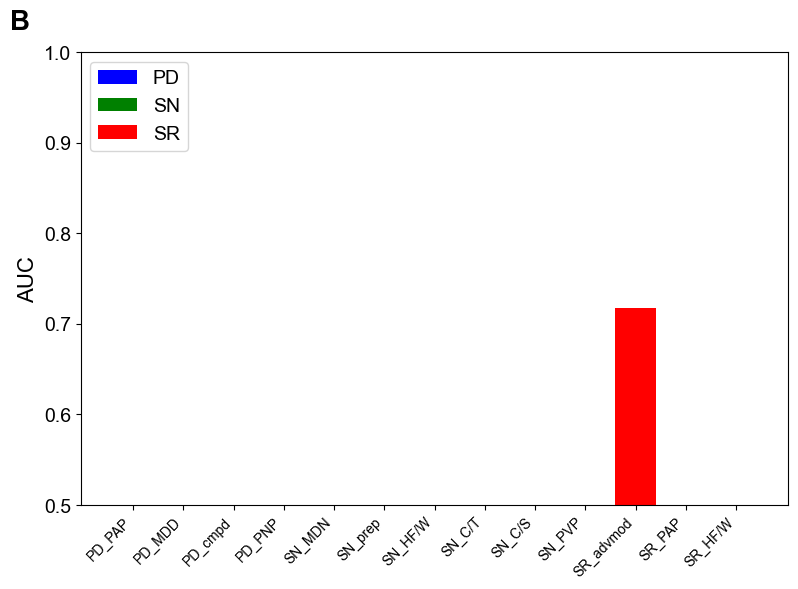

In [14]:
# 颜色定义，每个任务一个颜色
colors = {'PD': 'blue', 'SN': 'green', 'SR': 'red'}

# 按照组别排序特征：PD -> SN -> SR，并且每组内按 u_p_value 从小到大排序
sorted_features = []
sorted_p_values = []
sorted_aucs = []
sorted_tasks = []

# 按照组别顺序：PD -> SN -> SR
for task in ['PD', 'SN', 'SR']:
    # 每组内按u_p_value排序
    df_sorted = dict_discrim_feats[task].sort_values(by='u_p_value')
    # 添加按顺序排列的特征和对应的p值（每个任务的特征独立展示，不混合）
    sorted_features += [f"{task}_{feature}" for feature in df_sorted['feature']]  # 特征加上任务名称前缀
    sorted_p_values += df_sorted['u_p_value'].tolist()  # 添加对应的p值
    sorted_aucs += df_sorted['auc'].tolist()  # 添加对应的AUC值
    sorted_tasks += [task] * len(df_sorted)  # 记录任务类别


    
# 绘制p值的条形图
plt.figure(figsize=(8, 6))
# 绘制每个任务的柱状图，并保持按组别和u_p_value排序
for i, (feature, p_value, task) in enumerate(zip(sorted_features, sorted_p_values, sorted_tasks)):
    plt.bar(feature, p_value, color=colors[task], label=task if i == 0 or task != sorted_tasks[i-1] else "")
# 添加0.05的虚线
plt.axhline(y=0.05, color='black', linestyle='--')
# 设置标题和标签
plt.ylabel('p value', fontsize=16)
#plt.title('p-values by Feature for Each Task')
# 确保特征的顺序和标签清晰
plt.xticks(rotation=45, ha='right')
plt.yticks(fontsize=14)
# 调整Y轴范围，确保数据在合理范围内可见
#plt.ylim(0, max(sorted_p_values) + 0.005)  # 稍微增加一些间隙
plt.ylim(0, 0.06)
# 添加图例
plt.text(-0.1, 1.05, 'A', fontsize=20, fontweight='bold', fontname='Arial', transform=plt.gca().transAxes) # 在左上角添加子图序号
plt.legend(loc='upper left', fontsize=14)
plt.tight_layout()
plt.show()

# 绘制AUC的条形图
plt.figure(figsize=(8, 6))
# 绘制每个任务的柱状图，并保持按组别和AUC排序
for i, (feature, auc, task) in enumerate(zip(sorted_features, sorted_aucs, sorted_tasks)):
    plt.bar(feature, auc, color=colors[task], label=task if i == 0 or task != sorted_tasks[i-1] else "")
# 设置标题和标签
plt.ylabel('AUC', fontsize=16)
#plt.title('AUC by Feature for Each Task')
# 确保特征的顺序和标签清晰
plt.xticks(rotation=45, ha='right')
plt.yticks(fontsize=14)
# 调整Y轴范围，确保数据在合理范围内可见
plt.ylim(0.5, 1.0)  # 根据AUC的值范围设置Y轴范围
# 添加子图序号和图例
plt.text(-0.1, 1.05, 'B', fontsize=20, fontweight='bold', fontname='Arial', transform=plt.gca().transAxes)  # 在左上角添加子图序号
plt.legend(loc='upper left', fontsize=14)
plt.tight_layout()
plt.show()


# # 创建图表布局，2行1列
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))

# # 绘制p值的条形图 (ax1)
# for i, (feature, p_value, task) in enumerate(zip(sorted_features, sorted_p_values, sorted_tasks)):
#     ax1.bar(feature, p_value, color=colors[task], label=task if i == 0 or task != sorted_tasks[i-1] else "")

# # 添加0.05的虚线
# ax1.axhline(y=0.05, color='black', linestyle='--')
# ax1.set_ylabel('p value', fontsize=16)
# ax1.set_ylim(0, 0.06)
# ax1.set_xticks(range(len(sorted_features)))
# ax1.set_xticklabels(sorted_features, rotation=45, ha='right', fontsize=12)
# ax1.set_yticks([0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06])  # 设置y轴刻度
# ax1.set_yticklabels([0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06], fontsize=14)  # 设置y轴刻度
# ax1.text(-0.1, 1.05, 'A', fontsize=20, fontweight='bold', fontname='Arial', transform=ax1.transAxes)  # 在左上角添加子图序号
# ax1.legend(loc='upper left', fontsize=14)

# # 绘制AUC的条形图 (ax2)
# for i, (feature, auc, task) in enumerate(zip(sorted_features, sorted_aucs, sorted_tasks)):
#     ax2.bar(feature, auc, color=colors[task], label=task if i == 0 or task != sorted_tasks[i-1] else "")

# ax2.set_ylabel('AUC', fontsize=16)
# ax2.set_ylim(0.5, 1.0)
# ax2.set_xticks(range(len(sorted_features)))
# ax2.set_xticklabels(sorted_features, rotation=45, ha='right', fontsize=12)
# ax2.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])  # 设置y轴刻度
# ax2.set_yticklabels([0.5, 0.6, 0.7, 0.8, 0.9, 1.0], fontsize=14)  # 设置y轴刻度
# ax2.text(-0.1, 1.05, 'B', fontsize=20, fontweight='bold', fontname='Arial', transform=ax2.transAxes)  # 在左上角添加子图序号
# ax2.legend(loc='upper left', fontsize=14)

# # 调整布局
# plt.tight_layout()

# # 保存为SVG格式
# plt.savefig('combined_figure.svg', format='svg')

# plt.show()

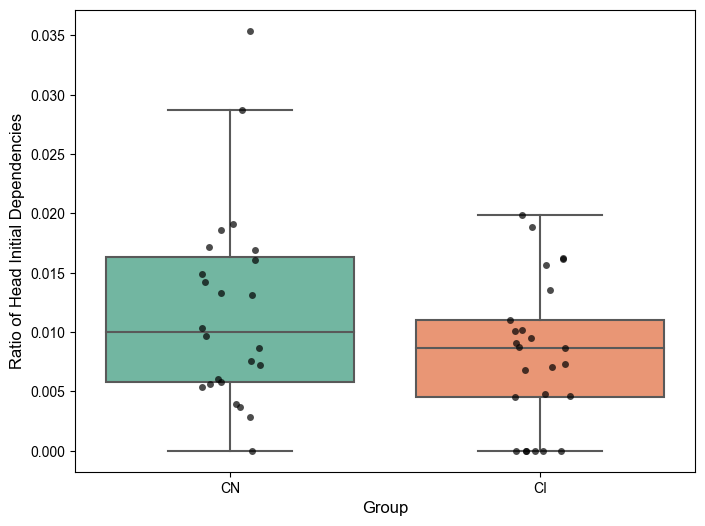

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

feature = 'cmpd'
pos_label = 'CI'
neg_label = 'CN'
lab_column = 'label'

# 分组
ci_group = data[task_type][data[task_type][lab_column] == pos_label]
cn_group = data[task_type][data[task_type][lab_column] == neg_label]

# 删除分类标签列
ci_group = ci_group.drop(columns=[lab_column])
cn_group = cn_group.drop(columns=[lab_column])

# 提取组别数据
cn_values = cn_group[feature]
ci_values = ci_group[feature]

# 创建一个DataFrame以便绘图
plot_data = pd.DataFrame({
    'group': ['CN'] * len(cn_values) + ['CI'] * len(ci_values),
    'ratio_head_init_deps': list(cn_values) + list(ci_values)
})

# 设置图形大小
plt.figure(figsize=(8, 6))

# 绘制箱线图
sns.boxplot(x='group', y='ratio_head_init_deps', data=plot_data, palette="Set2", showfliers=False)

# 叠加散点图
sns.stripplot(x='group', y='ratio_head_init_deps', data=plot_data, color='black', jitter=True, alpha=0.7)

# 添加标题和标签
plt.xlabel('Group', fontsize=12)
plt.ylabel('Ratio of Head Initial Dependencies', fontsize=12)

# 显示图形
plt.show()


C:\Users\yezi_\AppData\Local\Temp\ipykernel_31816\2284502901.py:12: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data['PD'].corr()


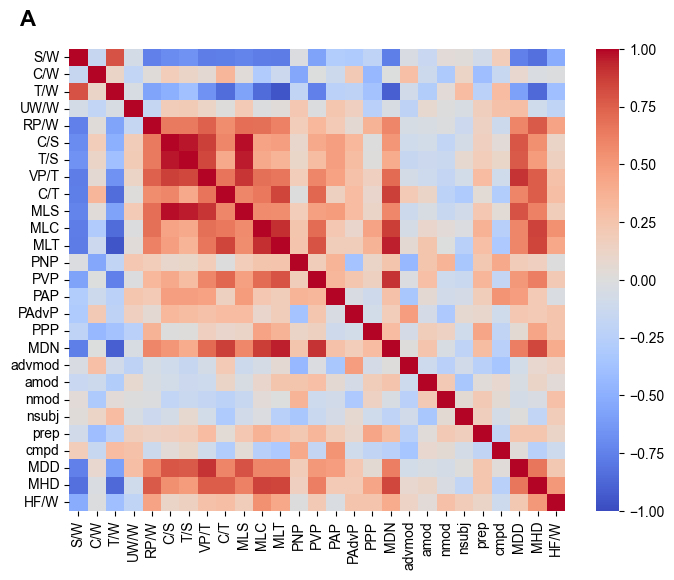

C:\Users\yezi_\AppData\Local\Temp\ipykernel_31816\2284502901.py:27: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data['SN'].corr()


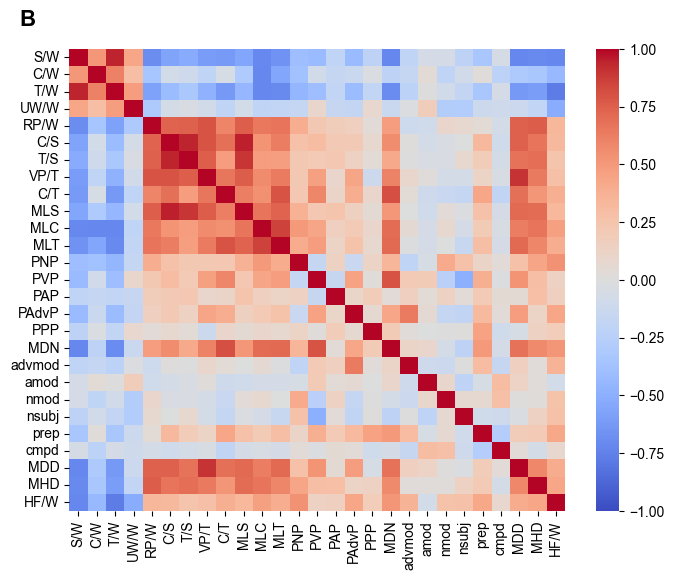

C:\Users\yezi_\AppData\Local\Temp\ipykernel_31816\2284502901.py:42: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data['SR'].corr()


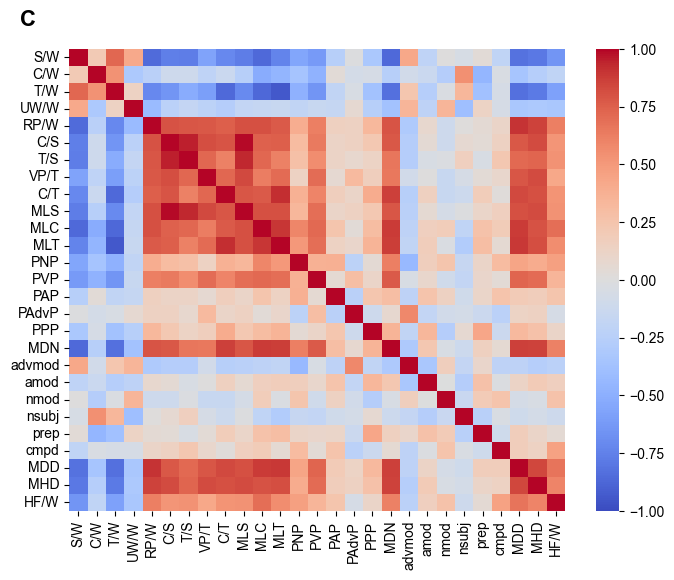

In [16]:
#绘制指标间相关性的热力图
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# 全局设置图形字体为 Arial
plt.rcParams['font.family'] = 'Arial'

#PD图
#data = pd.read_csv('features_郊游风景图_v7.csv')
#data = data.drop(columns=['date_subject', 'label'])
# 计算数值变量的相关性矩阵
corr_matrix = data['PD'].corr()
# 生成热图
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
#plt.title('Correlation Heatmap')
# 在左上角添加字母 "A"
plt.text(-0.1, 1.05, 'A', fontsize=16, fontweight='bold', fontname='Arial', transform=plt.gca().transAxes)
# 保存图片为 SVG 格式
plt.savefig("Corr-A.svg", format="svg", bbox_inches='tight')
plt.show()

#SN图
#data = pd.read_csv('features_三毛流浪记_v7.csv')
#data = data.drop(columns=['date_subject', 'label'])
# 计算数值变量的相关性矩阵
corr_matrix = data['SN'].corr()
# 生成热图
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
#plt.title('Correlation Heatmap')
# 在左上角添加字母 "A"
plt.text(-0.1, 1.05, 'B', fontsize=16, fontweight='bold', fontname='Arial', transform=plt.gca().transAxes)
# 保存图片为 SVG 格式
plt.savefig("Corr-B.svg", format="svg", bbox_inches='tight')
plt.show()

#SR图
#data = pd.read_csv('features_牛郎织女_v7.csv')
#data = data.drop(columns=['date_subject', 'label'])
# 计算数值变量的相关性矩阵
corr_matrix = data['SR'].corr()
# 生成热图
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
#plt.title('Correlation Heatmap')
# 在左上角添加字母 "A"
plt.text(-0.1, 1.05, 'C', fontsize=16, fontweight='bold', fontname='Arial', transform=plt.gca().transAxes)
# 保存图片为 SVG 格式
plt.savefig("Corr-C.svg", format="svg", bbox_inches='tight')
plt.show()

In [17]:
# Bonferroni 校正（废弃）
# t_p_values = results['t_p_value']
# # 使用 multipletests 进行 Bonferroni 校正
# _, t_p_values, _, _ = multipletests(t_p_values, alpha=0.05, method='bonferroni')
# results['t_p_value'] = t_p_values

# u_p_values = results['u_p_value']
# # 使用 multipletests 进行 Bonferroni 校正
# _, u_p_values, _, _ = multipletests(u_p_values, alpha=0.05, method='bonferroni')
# results['u_p_value'] = u_p_values

S/W PD-SN Correlation:


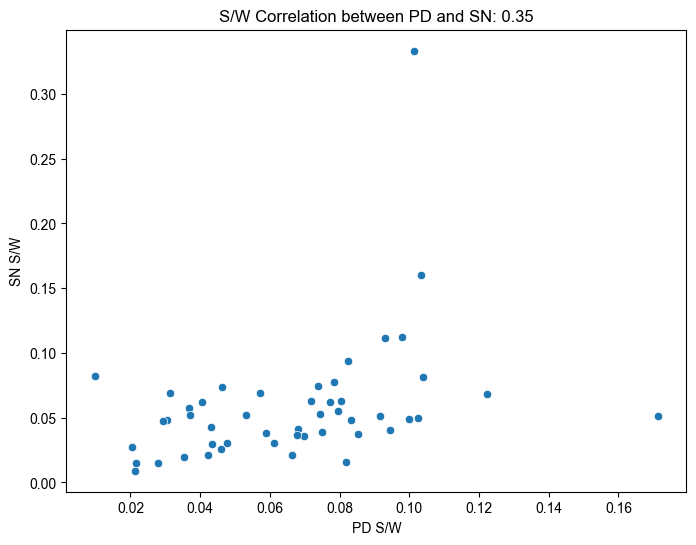

S/W SN-SR Correlation:


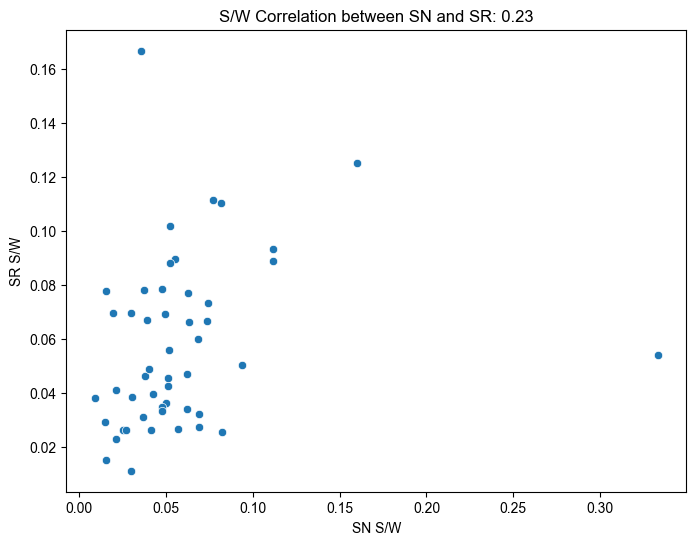

S/W PD-SR Correlation:


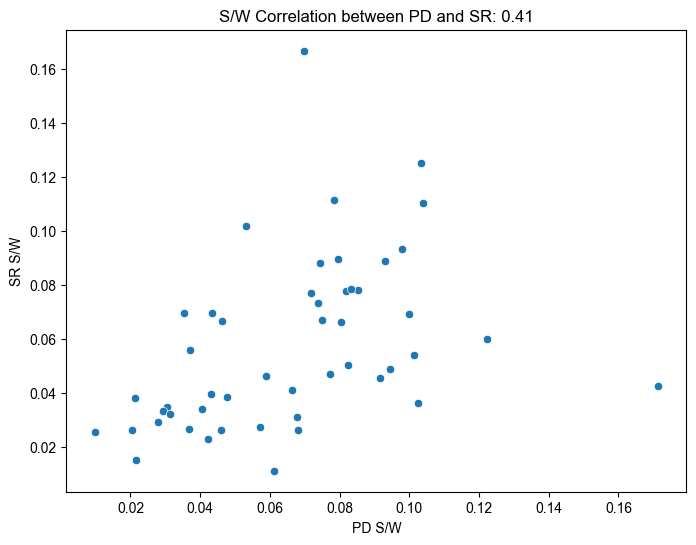

C/W PD-SN Correlation:


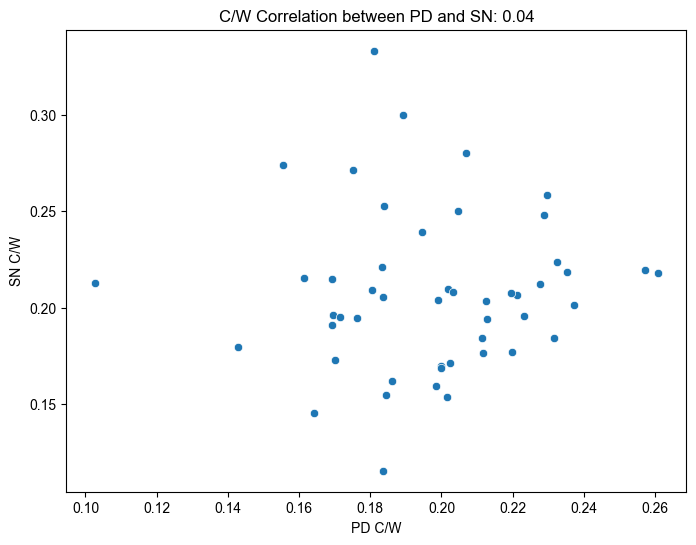

C/W SN-SR Correlation:


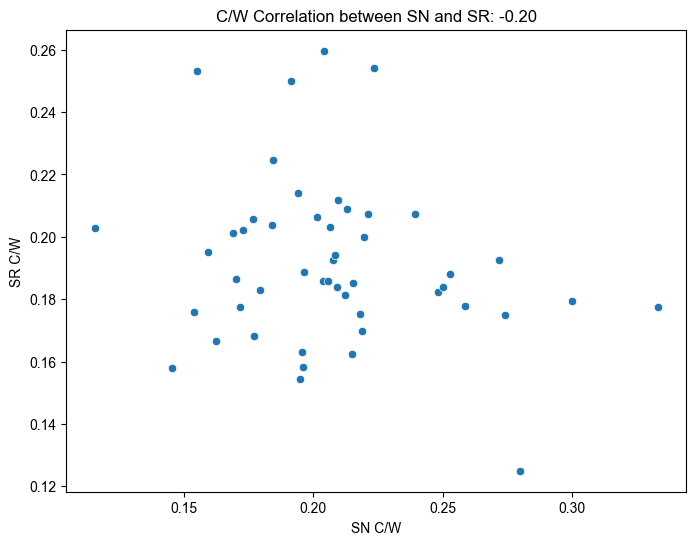

C/W PD-SR Correlation:


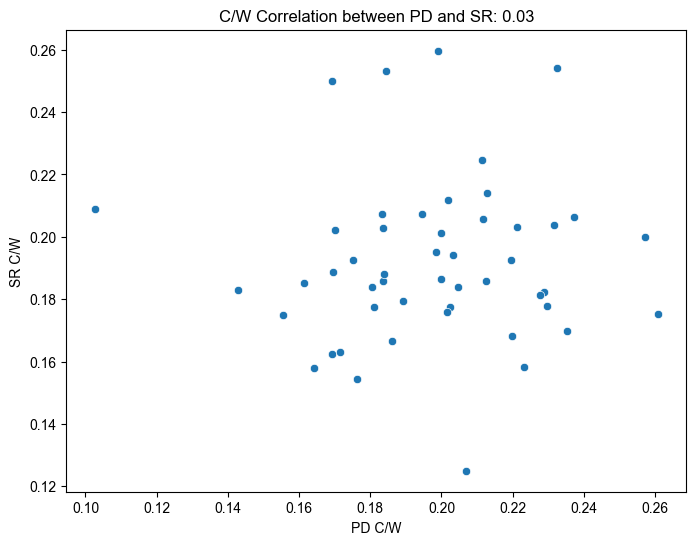

T/W PD-SN Correlation:


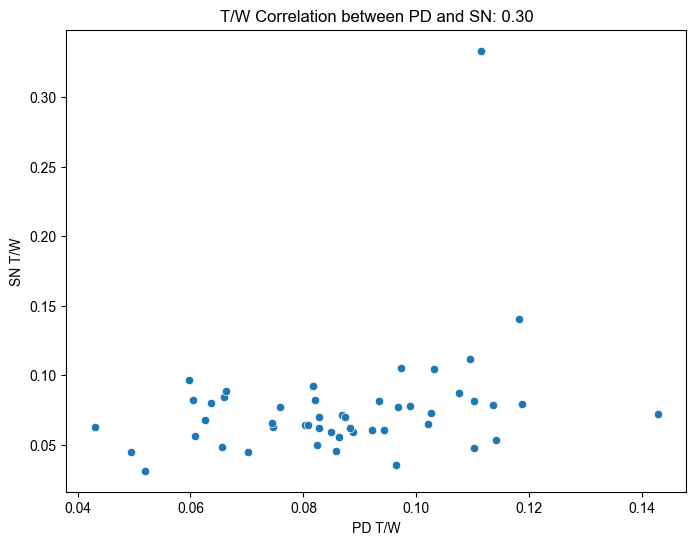

T/W SN-SR Correlation:


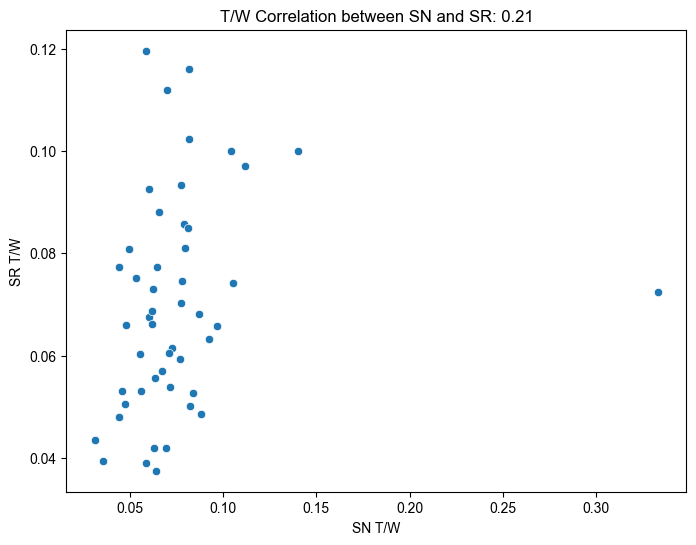

T/W PD-SR Correlation:


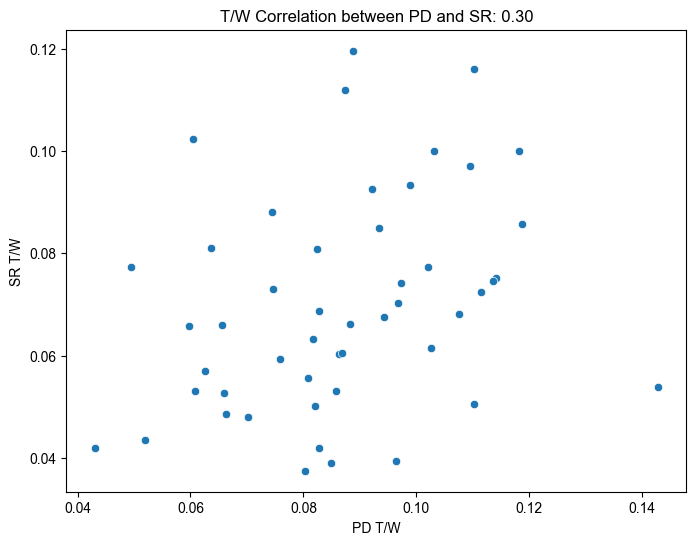

MHD PD-SN Correlation:


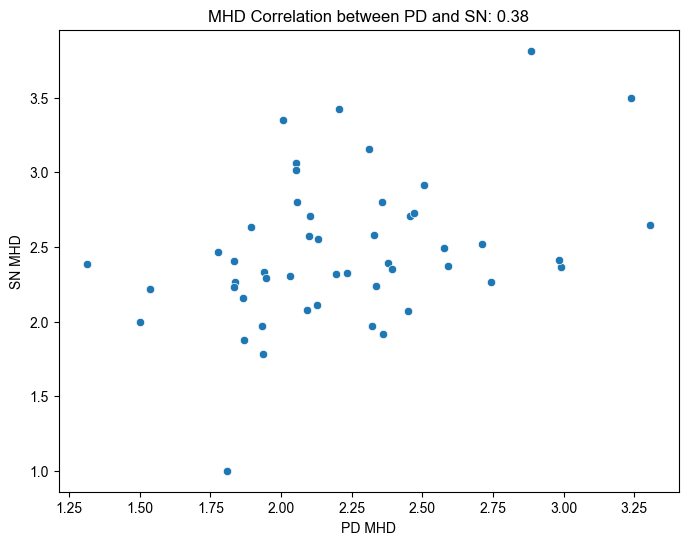

MHD SN-SR Correlation:


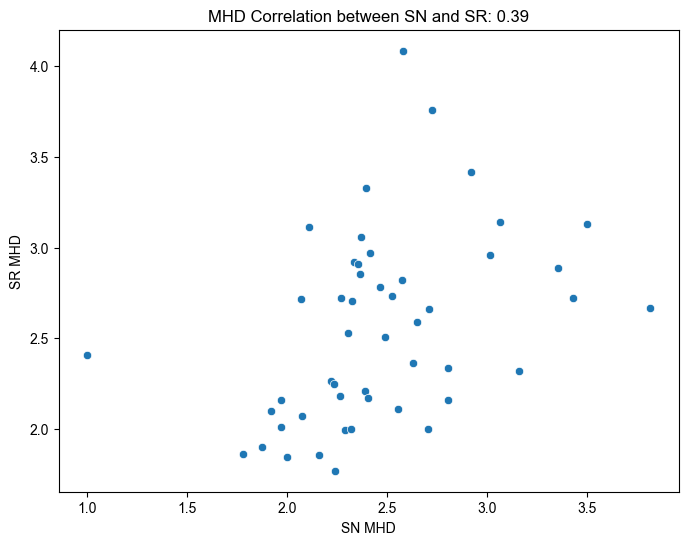

MHD PD-SR Correlation:


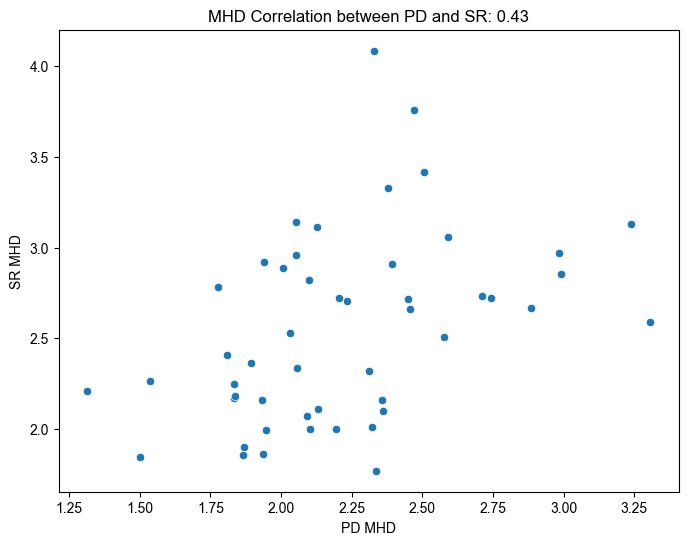

MLS PD-SN Correlation:


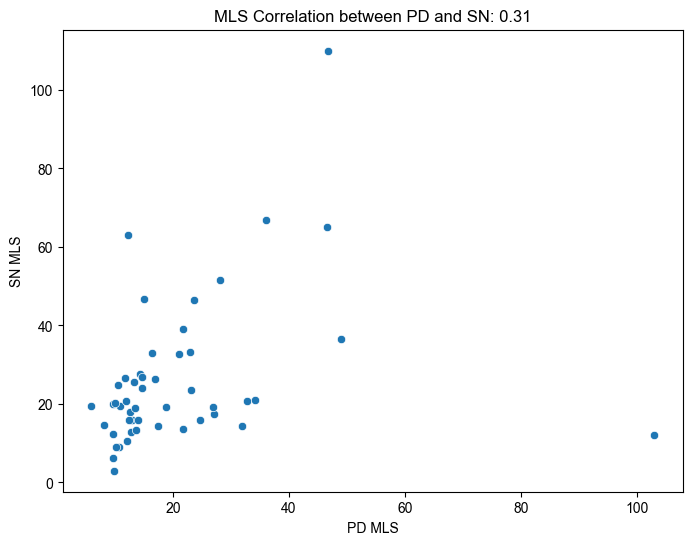

MLS SN-SR Correlation:


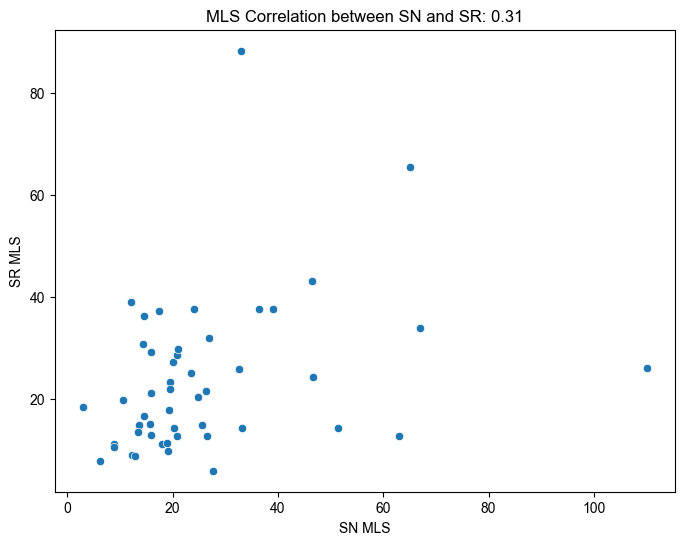

MLS PD-SR Correlation:


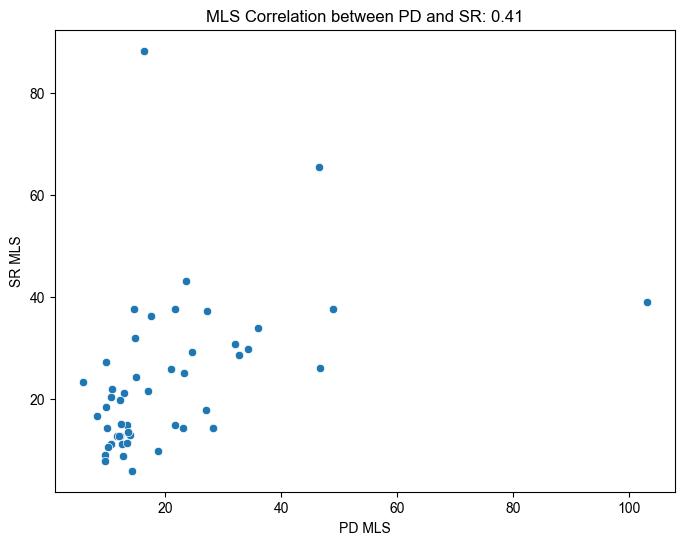

In [21]:
import seaborn as sns
# 提取特定特征
#features_to_compare = ['MDD', 'MDN', 'HF/W']  # 根据需要更改特征列表
features_to_compare = ['S/W', 'C/W', 'T/W', 'MHD', 'MLS']  # 根据需要更改特征列表

# 创建一个函数来计算相关性并生成散点图
def compare_and_plot(feature, data, task1, task2):
    x = data[task1][feature]
    y = data[task2][feature]

    # 计算 Pearson 相关系数
    correlation = x.corr(y, method='pearson')
    
    # 绘制散点图
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=x, y=y)
    plt.title(f'{feature} Correlation between {task1} and {task2}: {correlation:.2f}')
    plt.xlabel(f'{task1} {feature}')
    plt.ylabel(f'{task2} {feature}')
    plt.show()

    return correlation

# 比较并绘图
for feature in features_to_compare:
    print(f'{feature} PD-SN Correlation:')
    compare_and_plot(feature, data, 'PD', 'SN')
    
    print(f'{feature} SN-SR Correlation:')
    compare_and_plot(feature, data, 'SN', 'SR')
    
    print(f'{feature} PD-SR Correlation:')
    compare_and_plot(feature, data, 'PD', 'SR')